In [1]:
# !pip install uv==0.5.0
%pip install -e .. --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install pyTMD==2.2.7

In [ ]:
# !pip install -e /home/jovyan/Robbi/pyTMD

In [2]:
%load_ext autoreload
%autoreload 2

import odc.stac
import pandas as pd
import numpy as np
import xarray as xr
import pystac_client

from pyTMD.compute import tide_elevations

from pathlib import Path


GAUGE_X = 122.2183
GAUGE_Y = -18.0008
ENSEMBLE_MODELS = ["EOT20", "HAMTIDE11"]  # simplified for tests

In [3]:
cd ..

/home/jovyan/Robbi/eo-tides


## Load fixtures

In [ ]:
def load_satellite_ds():
    """
    Load a sample timeseries of Landsat 8 data using odc-stac
    """
    # Connect to stac catalogue
    catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

    # Set cloud defaults
    odc.stac.configure_rio(
        cloud_defaults=True,
        aws={"aws_unsigned": True},
    )

    # Build a query with the parameters above
    buffer = 0.08
    # buffer = 0.5
    bbox = [GAUGE_X - buffer, GAUGE_Y - buffer, GAUGE_X + buffer, GAUGE_Y + buffer]
    query = catalog.search(
        bbox=bbox,
        collections=["ga_ls8c_ard_3"],
        datetime="2020-01/2020-02",
    )

    # Search the STAC catalog for all items matching the query
    ds = odc.stac.load(
        list(query.items()),
        bands=["nbart_red"],
        crs="epsg:3577",
        resolution=30,
        groupby="solar_day",
        bbox=bbox,
        fail_on_error=False,
        chunks={"x": 100, "y": 200},
    )

    return ds

satellite_ds = load_satellite_ds()


def load_measured_tides_ds():
    """
    Load measured sea level data from the Broome ABSLMP tidal station:
    http://www.bom.gov.au/oceanography/projects/abslmp/data/data.shtml
    """
    # Metadata for Broome ABSLMP tidal station:
    # http://www.bom.gov.au/oceanography/projects/abslmp/data/data.shtml
    ahd_offset = -5.322

    # Load measured tides from ABSLMP tide gauge data
    measured_tides_df = pd.read_csv(
        "tests/data/IDO71013_2020.csv",
        index_col=0,
        parse_dates=True,
        na_values=-9999,
    )[["Sea Level"]]

    # Update index and column names
    measured_tides_df.index.name = "time"
    measured_tides_df.columns = ["tide_height"]

    # Apply station AHD offset
    measured_tides_df += ahd_offset

    # Return as xarray dataset
    return measured_tides_df.to_xarray()


def create_synthetic_hamtide11(base_dir="tests/data/tide_models_synthetic"):
    """
    Generates and exports synthetic HAMTIDE11 model data
    to test clipping functionality.
    """
    base_dir = Path(base_dir)  # Ensure base_dir is a Path object

    # Create coordinate arrays
    lon = np.arange(0, 360.125, 0.125)  # 2881 points
    lat = np.arange(-90, 90.125, 0.125)  # 1441 points

    # List of HAMTIDE11 tidal constituents
    constituents = ["2n", "k1", "k2", "m2", "n2", "o1", "p1", "q1", "s2"]

    # Create HAMTIDE11 output directory
    hamtide_dir = base_dir / "hamtide"
    hamtide_dir.mkdir(parents=True, exist_ok=True)

    # Create and save a NetCDF for each constituent
    for constituent in constituents:

        # Create synthetic HAMTIDE11 dataset with random data
        shape = (len(lat), len(lon))  # 1441, 2881
        data = np.random.random(shape).astype(np.float32)
        ds = xr.Dataset(
            {
                "RE": (("LAT", "LON"), data),
                "IM": (("LAT", "LON"), data),
                "AMPL": (("LAT", "LON"), data),
                "PHAS": (("LAT", "LON"), data),
            },
            coords={"LON": lon, "LAT": lat},
            attrs={"title": f"HAMTIDE11a: {constituent} ocean tide"},
        )

        # Export
        filename = hamtide_dir / f"{constituent}.hamtide11a.nc"
        ds.to_netcdf(filename)


def create_synthetic_eot20(base_dir="tests/data/tide_models_synthetic"):
    """
    Generates and exports synthetic EOT20 model data
    to test clipping functionality.
    """
    base_dir = Path(base_dir)  # Ensure base_dir is a Path object

    # Create coordinate arrays
    lon = np.arange(0, 360.125, 0.125)  # 2881 points
    lat = np.arange(-90, 90.125, 0.125)  # 1441 points

    # List of EOT20 tidal constituents
    constituents = [
        "2N2", "J1", "K1", "K2", "M2", "M4", "MF", "MM", "N2",
        "O1", "P1", "Q1", "S1", "S2", "SA", "SSA", "T2",
    ]

    # Create EOT20 output directory
    eot20_dir = base_dir / "EOT20/ocean_tides"
    eot20_dir.mkdir(parents=True, exist_ok=True)

    # Create and save a NetCDF for each constituent
    for constituent in constituents:

        # Create synthetic EOT20 dataset with random data
        shape = (len(lat), len(lon))  # 1441, 2881
        data = np.random.random(shape).astype(np.float64)

        # Add NaN values to match original
        mask = np.random.random(shape) < 0.2
        data[mask] = np.nan

        # Create the dataset
        ds = xr.Dataset(
            {
                "amplitude": (("lat", "lon"), data),
                "phase": (("lat", "lon"), data),
                "imag": (("lat", "lon"), data),
                "real": (("lat", "lon"), data),
            },
            coords={"lat": lat, "lon": lon},
            attrs={"title": f"DGFI-TUM global empirical ocean tide model"},
        )

        # Export
        filename = eot20_dir / f"{constituent}_ocean_eot20.nc"
        ds.to_netcdf(filename)


satellite_ds = load_satellite_ds()
measured_tides_ds = load_measured_tides_ds()
# create_synthetic_eot20()
# create_synthetic_hamtide11()

## Run tests

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_model.py --verbose -k test_model_tides_ensemble_dtype

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_model.py --verbose -k test_model_tides_errors

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_model.py --verbose -k test_model_tides_constituents

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_eo.py --verbose -k test_tag_tides_phases

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_stats.py --verbose -k test_tide_aliasing

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests --verbose

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_utils.py --verbose -k test_clip_models

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_utils.py --verbose -k test_list_models_extra_databases

In [ ]:
!export EO_TIDES_TIDE_MODELS=./tests/data/tide_models && pytest tests/test_stac.py --verbose -k test_get_bbox

## Updates to STAC functions

In [ ]:
import numpy as np
import pytest
from odc.geo.geom import point

from eo_tides.validation import load_gauge_gesla, ndwi_tide_corr

# Sample point in King Sound with variable model performance
y, x = -16.99636, 123.61017

# Calculate NDWI-tide correlations
corr_df, corr_da = ndwi_tide_corr(
    x=x,
    y=y,
    time=("2024-09", "2024-12"),
    cloud_cover=30,
    directory="../tests/data/tide_models/",
)

# Verify HAMTIDE11 comes out with lowest rank
assert corr_df.loc["HAMTIDE11", "rank"] == 3

# Verify correlations are approximately correct
assert np.allclose(corr_df.correlation, [0.77, 0.77, -0.12], atol=0.02)

# Verify valid percentages are between 0 and 1
assert corr_df["valid_perc"].between(0, 1).all()

# Verify data array contains expected dimensions and values
assert "tide_model" in corr_da.dims
assert "time" not in corr_da.dims
assert set(corr_da.tide_model.values) == set(["EOT20", "GOT5.5", "HAMTIDE11"])

# Assert that data envelops original point
corr_da.odc.geobox.extent.intersects(point(x, y, crs="EPSG:4326").to_crs(corr_da.odc.crs))


In [ ]:
y, x = -16.99636, 123.61017
directory = "../../tests/data/tide_models/"

corr_df, corr_da = ndwi_tide_corr(x=x, y=y, directory=directory)

In [36]:
from eo_tides.stac import stac_load

GAUGE_X = 122.2183
GAUGE_Y = -18.0008
crs, res = "utm", 30


test = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "name": "Central Paris outline"
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [2.252, 48.829],
            [2.264, 48.812],
            [2.289, 48.807],
            [2.320, 48.812],
            [2.350, 48.805],
            [2.380, 48.810],
            [2.410, 48.825],
            [2.425, 48.845],
            [2.430, 48.865],
            [2.422, 48.885],
            [2.405, 48.900],
            [2.380, 48.905],
            [2.350, 48.902],
            [2.320, 48.905],
            [2.290, 48.900],
            [2.270, 48.885],
            [2.255, 48.865],
            [2.252, 48.845],
            [2.252, 48.829]
          ]
        ]
      }
    }
  ]
}



ds, _ = stac_load(
    product="landsat-c2-l2",
    bands=["red"],
    time=("2020-01", "2020-06"),
    geopolygon=test,
    mask_geopolygon=True,
    crs=crs,
    resolution=res,
    dtype=None,
    groupby="solar_day",
    stac_query={
        "eo:cloud_cover": {"lt": 20},
        "platform": {"in": ["landsat-8"]},
    },
    fail_on_error=False,
    # chunks={},
)

ds["nbart_red"] = ds.red
ds


using dtype float32, True
Found 2 STAC items for landsat-c2-l2


<xarray.Dataset> Size: 3MB
Dimensions:      (time: 2, y: 372, x: 438)
Coordinates:
  * y            (y) float64 3kB 5.417e+06 5.417e+06 ... 5.406e+06 5.406e+06
  * x            (x) float64 4kB 4.451e+05 4.451e+05 ... 4.582e+05 4.582e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 16B 2020-04-01T10:40:31.424741 2020-05...
Data variables:
    red          (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan

In [32]:
mask_geopolygon = True
dtype = None
print("float32" if mask_geopolygon else dtype)

float32


In [37]:
ds.red  #.isel(time=0).plot.imshow(robust=True, size=5)

<xarray.DataArray 'red' (time: 2, y: 372, x: 438)> Size: 1MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(2, 372, 438), dtype=float32)
Coordinates:
  * y            (y) float64 3kB 5.417e+06 5.417e+06 ... 5.406e+06 5.406e+06
  * x            (x) float64 4kB 4.451e+05 4.451e+05 ... 4.582e+05 4.582e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 16B 2020-04-01T10:40:31.424741 2020-05...

In [25]:
ds.red

<xarray.DataArray 'red' (time: 2, y: 372, x: 438)> Size: 1MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(2, 372, 438), dtype=float32)
Coordinates:
  * y            (y) float64 3kB 5.417e+06 5.417e+06 ... 5.406e+06 5.406e+06
  * x            (x) float64 4kB 4.451e+05 4.451e+05 ... 4.582e+05 4.582e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 16B 2020-04-01T10:40:31.424741 2020-05...

In [42]:
from eo_tides.stac import load_ndwi_mpc

ds = load_ndwi_mpc(
    time=("2020-01", "2020-06"),
    geopolygon=test,
    mask_geopolygon=True,
    # crs=crs,
    # resolution=res,
    chunks={},
)

Found 21 STAC items for landsat-c2-l2
Found 49 STAC items for sentinel-2-l2a


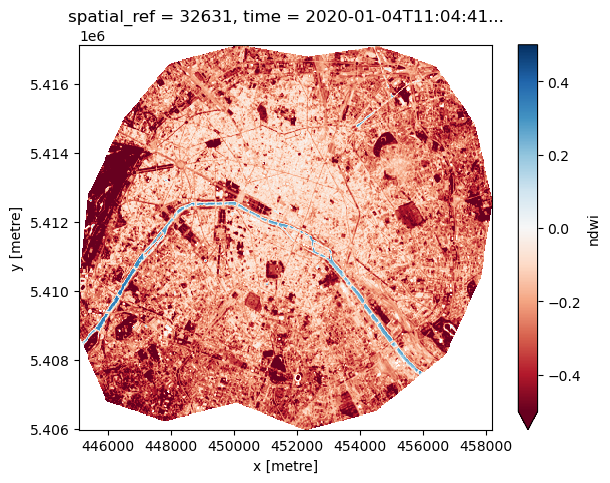

In [43]:
ds.ndwi.isel(time=0).plot.imshow(robust=True, size=5, cmap="RdBu", vmin=-0.5, vmax=0.5)

In [ ]:
from odc.geo.geom import BoundingBox
from odc.geo import geom

In [ ]:
from odc.stac._mdtools import output_geobox, _normalize_geometry

In [ ]:
# geopolygon = geom_3577
geopolygon = None
bbox = None
lon = (GAUGE_X - 0.08, GAUGE_X + 0.08)
lat = (GAUGE_Y - 0.08, GAUGE_Y + 0.08)

if geopolygon is not None:
    geopolygon = _normalize_geometry(geopolygon)
elif bbox is not None:
    geopolygon = geom.box(*bbox, crs="EPSG:4326") if isinstance(bbox, list | tuple) else bbox.polygon
elif lat is not None and lon is not None:
    #     # lon=(x0, x1), lat=(y0, y1)
    #     report_extra_args("lon,lat", "lon", "lat", *grid_params)
    #     x0, x1 = sorted(lon)
    #     y0, y1 = sorted(lat)
    #     geopolygon = geom.box(x0, y0, x1, y1, EPSG4326)
    # elif x is not None and y is not None:
    #     if crs is None:
    #         raise ValueError("Need to supply `crs=` when using `x=`, `y=`.")
    #     report_extra_args("x,y", "x", "y", *grid_params)
    #     x0, x1 = sorted(x)
    #     y0, y1 = sorted(y)
    #     geopolygon = geom.box(x0, y0, x1, y1, crs)

In [ ]:
bbox_list = [GAUGE_X - 0.08, GAUGE_Y - 0.08, GAUGE_X + 0.08, GAUGE_Y + 0.08]

bbox_4326 = BoundingBox(*bbox_list, crs="EPSG:4326")
geom_4326 = bbox_4326.polygon

bbox_3577 = bbox_4326.to_crs("EPSG:3577")
geom_3577 = bbox_3577.polygon

In [ ]:
import geopandas as gpd
gpd.GeoSeries(geom_4326.geom)

In [ ]:
geom_4326.exterior.coords

In [ ]:
from odc.geo.geom import polygon

geopolygon_4326 = polygon(
    outer=[
        (122.14, -18.08),
        (122.14, -17.92),
        (122.30, -17.92),
        (122.30, -18.08),
        (122.14, -18.08),
    ],
    crs="EPSG:4326",
)

In [ ]:
geopolygon_4326 = polygon(
    outer=[
        (122.14, -18.08),
        (122.14, -17.92),
        (122.30, -17.92),
        (122.30, -18.08),
        (122.14, -18.08),
    ],
    crs="EPSG:4326",
)

In [ ]:
list(geopolygon_4326.boundingbox)

In [ ]:
from odc.geo.geom import polygon

geopolygon_4326 = polygon(
    outer=[
        (122.14, -18.08),
        (122.14, -17.92),
        (122.30, -17.92),
        (122.30, -18.08),
        (122.14, -18.08),
    ],
    crs="EPSG:4326",
)

bbox = geopolygon_4326.boundingbox
bbox = tuple(geopolygon_4326.boundingbox)
bbox = list(geopolygon_4326.boundingbox)
geopolygon = gpd.GeoDataFrame(geometry=[geopolygon_4326.geom], crs="EPSG:4326")
geopolygon = gpd.GeoDataFrame(geometry=[geopolygon_4326.geom], crs="EPSG:4326").to_crs("EPSG:3577")
geopolygon = gpd.GeoSeries(geopolygon_4326.geom)
geopolygon = geopolygon_4326.geom
geopolygon = geopolygon_4326
lon, lat = (122.14, 122.30), (-18.08, -17.92)


def _get_bbox(bbox=None, geopolygon=None, lon=None, lat=None):
    """ """

    # If provided as a bounding box, either convert to `odc-geo`
    # bounding box or return as-is
    if bbox is not None:
        bbox_extracted = (
            BoundingBox(*bbox, crs="EPSG:4326")
            if isinstance(bbox, list | tuple)
            else bbox
        )
    
    # If data is provided as a geopolygon, normalise to `odc-geo`
    # geometry and extract bounding box
    elif geopolygon is not None:
        geopolygon_normalised = _normalize_geometry(geopolygon)
        bbox_extracted = geopolygon_normalised.boundingbox

    # If provided as lon/lat ranges, convert to an `odc-geo` bounding box
    elif (lon is not None) and (lat is not None):
        bbox_extracted = BoundingBox.from_xy(lon, lat, crs="EPSG:4326")

    # Raise error if no valid inputs are provided
    else:
        err_msg = "Must provide both `lon` and `lat`, or `geopolygon`, or `bbox`."
        raise Exception(err_msg)

    # Convert bounding box to EPSG:4326 if required
    if not bbox_extracted.crs.geographic:
        bbox_extracted = bbox_extracted.to_crs("EPSG:4326")

    return bbox_extracted


bbox_4326 = _get_bbox(bbox=bbox, geopolygon=geopolygon, lon=lon, lat=lat)

assert bbox_4326.crs.geographic
assert isinstance(bbox_4326, odc.geo.geom.BoundingBox)
assert bbox_4326.polygon.intersects(geopolygon_4326)

In [ ]:
assert bbox_4326.crs.geographic
assert isinstance(bbox_4326, odc.geo.geom.BoundingBox)
assert bbox_4326.polygon.intersects(geopolygon_4326)

In [ ]:
geopolygon_4326

In [ ]:
import numpy as np
import odc.stac
import planetary_computer
import pystac_client


product="landsat-c2-l2"
time=("2020-01", "2020-02")
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Connect to client
catalog = pystac_client.Client.open(
   stac_url,
    modifier=(planetary_computer.sign_inplace if "planetarycomputer" in stac_url else None),
)

# Find matching items
search = catalog.search(
    collections=product,
    bbox=(bbox_4326.left, bbox_4326.bottom, bbox_4326.right, bbox_4326.top),
    datetime=time,
    # query=stac_query if stac_query is not None else None,
)

# Check how many items were returned
items = search.item_collection()
print(f"Found {len(items)} STAC items for {product}")

In [ ]:
load_params = {"chunks": {}}

# Load with ODC STAC
ds = odc.stac.load(
    items=items,
    bands=["red"],
    bbox=bbox,
    geopolygon=geopolygon,
    lon=lon,
    lat=lat,
    **load_params,
)

# return ds, items

    
# bbox_4326.explore()

In [ ]:
ds.odc.geobox.explore()

In [ ]:
bbox = bbox_3577
isinstance(bbox, list | tuple)
# BoundingBox(*bbox, crs="EPSG:4326") if isinstance(bbox, list | tuple) else bbox

In [ ]:
test = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "name": "Eiffel Tower bounding box"
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [2.2935, 48.8579],
            [2.2935, 48.8589],
            [2.2955, 48.8589],
            [2.2955, 48.8579],
            [2.2935, 48.8579]
          ]
        ]
      }
    }
  ]
}




In [ ]:
ds, _ = stac_load(
    product="landsat-c2-l2",
    bands=["red"],
    time=("2020-01", "2020-02"),
    geopolygon=test,
    crs=crs,
    resolution=res,
    groupby="solar_day",
    stac_query={
        "platform": {"in": ["landsat-8"]},
    },
    fail_on_error=False,
    chunks={},
)

In [ ]:
ds

In [ ]:

import odc.stac
import pandas as pd

import planetary_computer
import pystac_client
import pytest

# Connect to STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query with the parameters above
query = catalog.search(
    bbox=bbox,
    collections=["landsat-c2-l2"],
    datetime="2020-01/2020-02",
    query={
        "platform": {"in": ["landsat-8"]},
    },
)

# Search the STAC catalog for all items matching the query
ds_old = odc.stac.load(
    list(query.items()),
    bands=["red"],
    crs=crs,
    resolution=res,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

# Rename for compatibility with original DEA tests
ds_old["nbart_red"] = ds_old.red
ds_old

## DE Africa testing

In [ ]:
from eo_tides.model import model_tides

model_tides(
    x=(-17.334229, -17.314229),
    y=(14.717859, 14.737859),
    time=["2020-09-01"],
    model="FES2014",
    # directory="/gdata1/data/tide_models/",
    # directory="/var/share/tide_models/",
    directory="/home/jovyan/tide_models_africa",
)

In [ ]:
from eo_tides.utils import clip_models

In [ ]:
clip_models(input_directory="/gdata1/data/tide_models/",
            output_directory="/home/jovyan/tide_models_africa",
            model="FES2014",
            bbox=(-25.36055496,-42.96972610,63.49575409,41.34040909),
           overwrite=True)




## Constituents bug

In [ ]:
import eo_tides

eo_tides.model.model_tides(
    x=122.2183,
    y=-18.0008,
    time=pd.date_range("2020-01-01", "2020-01-07", freq="1h"),
    constituents=['m2', 's2'],   # works with `None`
    model="EOT20",  # also fails with `FES2022`
    directory="./tests/data/tide_models",
).tide_height.plot()

## Tests for aliasing

In [ ]:
import pytest
import pandas as pd
from eo_tides.stats import tide_aliasing 

@pytest.mark.parametrize(
    "satellites, c, units, style, expect_error",
    [
        (["landsat"], ["m2", "k1"], "days", False, None),
        (["sentinel-2"], None, "hours", True, None),
        (["swot", "landsat"], ["k1"], "years", False, None),
        (["landsat"], ["mm"], "days", False, None),
        (["invalid-sat"], ["m2"], "days", False, ValueError),
        (["landsat"], ["m2"], "centuries", False, ValueError),
    ],
)
def test_tide_aliasing(satellites, c, units, style, expect_error):
    if expect_error:
        with pytest.raises(expect_error):
            tide_aliasing(satellites, c=c, units=units, style=style)
    else:
        result = tide_aliasing(satellites, c=c, units=units, style=style)

        # Verify output is a dataframe
        if style:
            assert isinstance(result, pd.io.formats.style.Styler)
        else:
            assert isinstance(result, pd.DataFrame)

        # Verify
        assert "name" in result.columns
        assert "type" in result.columns
        assert "period" in result.columns

        for sat in satellites:
            assert ("aliasing_period", sat) in result.columns


In [ ]:
satellites, c, units, style, expect_error = {"custom-sat1": 6, "custom-sat2": 10}, None, "hours", True, None
test_tide_aliasing(satellites, c, units, style, expect_error)

In [ ]:
tide_aliasing(satellites={"boo": 6})

## Tests for errors

In [ ]:
import pytest
import numpy as np
from eo_tides.model import model_tides


@pytest.mark.parametrize(
    "bad_args, expected_exception",
    [
        ({"time": None}, ValueError),
        ({"method": "cubic"}, ValueError),
        ({"output_units": "feet"}, ValueError),
        ({"output_format": "stacked"}, ValueError),
        ({"x": np.array(["a", "b", "c"])}, TypeError),
        ({"y": np.array(["a", "b", "c"])}, TypeError),
        ({"x": np.array([1, 2])}, ValueError),
        (
            {"mode": "one-to-one", "time": np.array(["2025-01-01", "2025-01-02"])},
            ValueError,
        ),
    ],
    ids=[
        "missing_time",
        "invalid_method",
        "invalid_units",
        "invalid_format",
        "non_numeric_x",
        "non_numeric_y",
        "x_y_length_mismatch",
        "time_length_mismatch",
    ],
)
def test_model_tides_validation(bad_args, expected_exception):

    # Dummy valid inputs
    args = {
        "x": GAUGE_X,
        "y": GAUGE_Y,
        "time": np.array(
            ["2025-01-01", "2025-01-02", "2025-01-03"], dtype="datetime64[ns]"
        ),
        "directory": "/var/share/tide_models/",
    }

    # Update with bad kwargs
    args.update(bad_args)

    # Verify error is raised
    with pytest.raises(expected_exception):
        model_tides(**args)

In [ ]:
import os
import pathlib
import pytest

from eo_tides.utils import _set_directory  # Replace with actual import



# Use monkeypatch to test setting and unsetting environment var
@pytest.mark.parametrize(
    "directory,env_var,expected_exception",
    [
        # Case 1: No directory, no env var → Exception
        (None, None, Exception),
        
        # Case 2: Directory set, but path doesn't exist → FileNotFoundError
        ("/some/nonexistent/path", None, FileNotFoundError),

        # Case 3: Env var set, but path doesn't exist → FileNotFoundError
        (None, "/some/nonexistent/path", FileNotFoundError),
    ],
    ids=["no_directory_or_env", "invalid_dir", "invalid_env_var"]
)
def test_set_directory_errors(monkeypatch, directory, env_var, expected_exception):
    # Ensure env var is unset unless explicitly requested
    if env_var is None:
        monkeypatch.delenv("EO_TIDES_TIDE_MODELS", raising=False)
    else:
        monkeypatch.setenv("EO_TIDES_TIDE_MODELS", env_var)

    # with pytest.raises(expected_exception):
    _set_directory(directory)

In [ ]:
import pytest
from unittest.mock import patch

from eo_tides.utils import _standardise_models  # Replace with actual import


# Test expected failures during model standardisation
@pytest.mark.parametrize(
    "model, ensemble_models, err_msg",
    [
        # Case 1: Duplicate models
        (["EOT20", "EOT20"], None, "duplicate values"),

        # Case 2: Unsupported model
        (["bad_model"], None, "not valid"),

        # Case 3: Model valid but not available
        (["FES2012"], None, "not available"),

        # Case 4: Ensemble requested but ensemble model not available
        (["ensemble"], ["EOT20", "FES2012"], "ensemble models are not available"),
    ],
    ids=["duplicate_model", "invalid_model", "unavailable_model", "unavailable_ensemble"],
)
def test_standardise_models_errors(model, ensemble_models, err_msg):

    with pytest.raises(ValueError, match=err_msg):
        _standardise_models(
            model=model,
            directory="../tests/data/tide_models",
            ensemble_models=ensemble_models,
        )

In [ ]:
test_standardise_models_validation(["ensemble"], ["EOT20", "FES2012"], "ensemble models are not available")

## Tests for custom models

In [ ]:
import pyTMD

custom_dict = {
    "format": "FES-netcdf",
    "model_file": [
        "EOT20/ocean_tides/2N2_ocean_eot20.nc",
        "EOT20/ocean_tides/J1_ocean_eot20.nc",
        "EOT20/ocean_tides/K1_ocean_eot20.nc",
        "EOT20/ocean_tides/K2_ocean_eot20.nc",
        "EOT20/ocean_tides/M2_ocean_eot20.nc",
        "EOT20/ocean_tides/M4_ocean_eot20.nc",
        "EOT20/ocean_tides/MF_ocean_eot20.nc",
        "EOT20/ocean_tides/MM_ocean_eot20.nc",
        "EOT20/ocean_tides/N2_ocean_eot20.nc",
        "EOT20/ocean_tides/O1_ocean_eot20.nc",
        "EOT20/ocean_tides/P1_ocean_eot20.nc",
        "EOT20/ocean_tides/Q1_ocean_eot20.nc",
        "EOT20/ocean_tides/S1_ocean_eot20.nc",
        "EOT20/ocean_tides/S2_ocean_eot20.nc",
        "EOT20/ocean_tides/SA_ocean_eot20.nc",
        "EOT20/ocean_tides/SSA_ocean_eot20.nc",
        "EOT20/ocean_tides/T2_ocean_eot20.nc"
    ],
    "name": "EOT20_custom",
    "reference": "https://doi.org/10.17882/79489",
    "scale": 0.01,
    "type": "z",
    "variable": "tide_ocean",
    "version": "EOT20"
}



pyTMD.io.model("/gdata1/data/tide_models").from_dict(custom_dict).to_dict()

In [ ]:
# Import model def from dict
model = pyTMD.io.model(directory="/var/share/tide_models/").from_dict(custom_dict)
assert model.verify

# Read tidal constants and interpolate to grid points
amp, ph, c = model.extract_constants(155, -32)

In [ ]:
model.model_file

In [ ]:
# Import model def from file
model = pyTMD.io.model(directory="/var/share/tide_models/").from_file("tests/data/model_EOT20custom.json")
assert model.verify

# Read tidal constants and interpolate to grid points
amp, ph, c = model.extract_constants(155, -32)

In [ ]:
model.model_file

In [ ]:
model.validate_format()

In [ ]:
pyTMD.io.model("/gdata1/data/tide_models").from_file("/gdata1/data/tide_models/INATIDES/model_INATIDES.json").to_dict()

In [ ]:
import pyTMD
import pandas as pd
from eo_tides.utils import _custom_model_definitions, list_models
from eo_tides.model import model_tides


In [ ]:
available_models, supported_models = list_models(
    directory="/var/share/tide_models/",
    custom_models=[custom_dict],
    show_supported=False,
)

In [ ]:

custom_dict = {
    "format": "FES-netcdf",
    "model_file": [
        "EOT20/ocean_tides/2N2_ocean_eot20.nc",
        "EOT20/ocean_tides/J1_ocean_eot20.nc",
        "EOT20/ocean_tides/K1_ocean_eot20.nc",
        "EOT20/ocean_tides/K2_ocean_eot20.nc",
        "EOT20/ocean_tides/M2_ocean_eot20.nc",
        "EOT20/ocean_tides/M4_ocean_eot20.nc",
        "EOT20/ocean_tides/MF_ocean_eot20.nc",
        "EOT20/ocean_tides/MM_ocean_eot20.nc",
        "EOT20/ocean_tides/N2_ocean_eot20.nc",
        "EOT20/ocean_tides/O1_ocean_eot20.nc",
        "EOT20/ocean_tides/P1_ocean_eot20.nc",
        "EOT20/ocean_tides/Q1_ocean_eot20.nc",
        "EOT20/ocean_tides/S1_ocean_eot20.nc",
        "EOT20/ocean_tides/S2_ocean_eot20.nc",
        "EOT20/ocean_tides/SA_ocean_eot20.nc",
        "EOT20/ocean_tides/SSA_ocean_eot20.nc",
        "EOT20/ocean_tides/T2_ocean_eot20.nc"
    ],
    "name": "EOT20_custom",
    "reference": "https://doi.org/10.17882/79489",
    "scale": 0.01,
    "type": "z",
    "variable": "tide_ocean",
    "version": "EOT20"
}


model_tides(
    x=115.313154,
    y=-8.668534,
    time=pd.date_range("2022-01-01", "2022-01-31", freq="1h"),
    model="EOT20_custom",
    directory="/var/share/tide_models/",
    custom_models=[custom_dict],
)

In [ ]:
df = model_tides(
    x=115.313154,
    y=-8.668534,
    time=pd.date_range("2022-01-01", "2022-01-31", freq="1h"),
    model=["INATIDES", "EOT20", "HAMTIDE11"],
    directory="/gdata1/data/tide_models",
    custom_models=["/gdata1/data/tide_models/INATIDES/model_INATIDES.json"],
    output_format="wide",
    parallel=False,
)

In [ ]:
# Test available tide models
def test_list_models_custom():
    # Verify that custom models are added to lists of
    # available and supported models
    available_models, supported_models = list_models(
        directory="./tests/data/tide_models", 
        custom_models=["./tests/data/model_EOT20custom.json"],
    )
    assert "EOT20_custom" in available_models
    assert "EOT20_custom" in supported_models


## Test new PyTMD version

In [ ]:
from eo_tides.model import model_tides
from eo_tides.validation import eval_metrics
import numpy as np
import pandas as pd

directory = "/var/share/tide_models/"

# Time the spline method
modelled_tides_df = model_tides(
   x=GAUGE_X,
   y=GAUGE_Y,
   time=measured_tides_ds.time,
   model="all",
   directory=directory,
)

In [ ]:
modelled_tides_df.groupby("tide_model").apply(lambda z: eval_metrics(x=measured_tides_ds.tide_height, y=z.tide_height))

In [ ]:
modelled_tides_df.groupby("tide_model").apply(lambda z: eval_metrics(x=measured_tides_ds.tide_height, y=z.tide_height))

## Ensemble dtype

In [ ]:
from eo_tides.model import model_tides
from eo_tides.model import ensemble_tides

# Set modelling location based on bbox centroid
time = pd.date_range(start="2000-01", end="2001-03", freq="5h")

# Model using unclipped vs clipped files
tide_df = model_tides(
    x=GAUGE_X,
    y=GAUGE_Y,
    time=time,
    model="all",
    directory="./tests/data/tide_models",
)

# tide_df["tide_height"] = tide_df.tide_height.astype("float64")
# ensemble_df = ensemble_tides(tide_df, ensemble_models=["EOT20", "HAMTIDE11"], crs="EPSG:4326")

# print(ensemble_df)
# print(ensemble_df.dtypes)

In [ ]:
print(tide_df)

In [ ]:
import pandas as pd
import numpy as np

# Create data with a cross product approach
data = pd.DataFrame({
    'time': pd.date_range(start='2000-01-01', periods=5, freq='5h').repeat(2),
    'x': 122.2183,
    'y': -18.0008,
    'tide_model': ['EOT20', 'HAMTIDE11'] * 5,
    'tide_height': np.random.uniform(-4, 3, 10).astype("float32")
})

# Set multi-index
data = data.set_index(['time', 'x', 'y'])

print(data)

## Test clipping

In [ ]:
from eo_tides.utils import clip_models
from eo_tides.model import model_tides

# @pytest.mark.parametrize("bbox, name", [
#     ((-166, 14, -151, 29), "hawaii"),
#     ((-123.530273, 36.949892, -121.376953, 38.479395), "sanfran"),
#     ((-17.753906, -36.031332, 60.996094, 37.857507), "africa"),
#     ((-13, 49, 6, 60), "uk"),
#     ((105.292969, -47.872144, 160.312500, -5.266008), "aus"),
#     ((-256.640625, 7.013668, -119.794922, 63.391522), "pacific"),
# ])

bbox, name = (105.292969, -47.872144, 160.312500, -5.266008), "aus"

def test_clip_models_bboxes(bbox, name):

    # Set input and output paths
    in_dir = "tests/data/tide_models_synthetic/"
    out_dir = f"tests/data/tide_models_synthetic_{name}/"

    # Clip models to input bbox
    clip_models(
        input_directory=in_dir,
        output_directory=out_dir,
        bbox=bbox,
        model="HAMTIDE11",
        overwrite=True,
    )

    # Set modelling location based on bbox centroid
    x, y = odc.geo.geom.BoundingBox(*bbox, crs="EPSG:4326").polygon.centroid.xy
    time = pd.date_range(start="2000-01", end="2001-03", freq="5h")

    # Model using unclipped vs clipped files
    df_unclipped = model_tides(
        x=x,
        y=y,
        time=time,
        model="HAMTIDE11",
        directory=in_dir,
        crop=False,
    )
    df_clipped = model_tides(
        x=x,
        y=y,
        time=time,
        model="HAMTIDE11",
        directory=out_dir,
        crop=False,
    )

    # Verify both produce the same results
    assert np.allclose(df_unclipped.tide_height, df_clipped.tide_height)

test_clip_models_bboxes(bbox, name)

## Add tide phase

In [ ]:
from eo_tides.eo import tag_tides
import xarray as xr

# Use tag_tides to model both phases and tide heights
tagged_tides_ds = tag_tides(
    satellite_ds,
    return_phases=True,
    directory="./tests/data/tide_models",
)

# Verify output is an xarray.Dataset
assert isinstance(tagged_tides_ds, xr.Dataset)

# Verify vars are as expected
expected_vars = ["tide_height", "tide_phase"]
assert set(expected_vars) == set(tagged_tides_ds.data_vars)

# Verify tide_phase values
expected_phases = ["low-flow", "high-flow", "low-ebb", "low-flow", "low-ebb", "low-flow", "high-flow"]
assert tagged_tides_ds.tide_phase.values.tolist() == expected_phases

# Assert tide_model dim has been squeezed out
assert "tide_model" not in tagged_tides_ds.dims

# Model two models at once
tagged_tides_ds = tag_tides(
    satellite_ds,
    model=["EOT20", "GOT5.5"],
    return_phases=True,
    directory="./tests/data/tide_models",
)

# Assert that output now has a tide_model dimension
assert "tide_model" in tagged_tides_ds.dims
assert len(tagged_tides_ds["tide_model"]) == 2

## Update `tide_stats`


Aim: internal `_tide_statistics` function that takes a stack of input observed and modelled tides in _both_ pandas and xarray format, and returns statistics in corresponding format

In [ ]:
import numpy as np
import pandas as pd
import pytest

from eo_tides.stats import pixel_stats, tide_stats

GAUGE_X = 122.2183
GAUGE_Y = -18.0008



In [ ]:
models = ["EOT20", "GOT5.5"]

# Calculate tidal stats
tidal_stats_df = tide_stats(
    satellite_ds,
    model=models,
    directory="./tests/data/tide_models",
)

# assert isinstance(tidal_stats_df, pd.Series)


In [ ]:
satellite_ds

In [ ]:
stats_ds = pixel_stats(
    satellite_ds,
    model=models,
    resample=False,
    directory="./tests/data/tide_models",
)

In [ ]:
list(stats_ds.data_vars)

## Ensemble updates

In [ ]:
dir_path = "./tests/data/tide_models"


from eo_tides.model import model_tides

# Input params
good_hamtide11 = -17.58549, 123.59414
good_eot20 = -17.1611, 123.3406
y = [good_eot20[0], good_hamtide11[0]]
x = [good_eot20[1], good_hamtide11[1]]

ENSEMBLE_MODELS = ["EOT20", "HAMTIDE11"]

# times = pd.date_range("2020", "2021", periods=2)

# # Default, only ensemble requested
# modelled_tides_df = model_tides(
#     x=x,
#     y=y,
#     time=times,
#     model="ensemble",
#     directory=dir_path,
#     ensemble_models=ENSEMBLE_MODELS,
# )

# assert modelled_tides_df.index.names == ["time", "x", "y"]
# assert modelled_tides_df.columns.tolist() == ["tide_model", "tide_height"]
# assert all(modelled_tides_df.tide_model == "ensemble")

# Default, ensemble + other models requested
models = ["EOT20", "HAMTIDE11", "ensemble"]
# modelled_tides_df = model_tides(
#     x=x,
#     y=y,
#     time=times,
#     model=models,
#     directory=dir_path,
#     ensemble_models=ENSEMBLE_MODELS,
# )

# assert modelled_tides_df.index.names == ["time", "x", "y"]
# assert modelled_tides_df.columns.tolist() == ["tide_model", "tide_height"]
# assert set(modelled_tides_df.tide_model) == set(models)
# assert np.allclose(
#     modelled_tides_df.tide_height.values,
#     [
#         0.094,
#         -3.202,
#         0.409,
#         -3.098,
#         0.803,
#         0.664,
#         0.989,
#         1.011,
#         0.449,
#         -1.269,
#         0.699,
#         -1.043,
#     ],
#     atol=0.02,
# )

# # One-to-one mode
# modelled_tides_df = model_tides(
#     x=x,
#     y=y,
#     time=times,
#     model=models,
#     mode="one-to-one",
#     directory=dir_path,
#     ensemble_models=ENSEMBLE_MODELS,
# )

# assert modelled_tides_df.index.names == ["time", "x", "y"]
# assert modelled_tides_df.columns.tolist() == ["tide_model", "tide_height"]
# assert set(modelled_tides_df.tide_model) == set(models)

# # Wide mode, default
# modelled_tides_df = model_tides(
#     x=x,
#     y=y,
#     time=times,
#     model=models,
#     output_format="wide",
#     directory=dir_path,
#     ensemble_models=ENSEMBLE_MODELS,
# )

# # Check that expected models exist, and that ensemble is approx average
# # of other two models
# assert set(modelled_tides_df.columns) == set(models)
# assert np.allclose(
#     0.5 * (modelled_tides_df.EOT20 + modelled_tides_df.HAMTIDE11),
#     modelled_tides_df.ensemble,
# )

# # Wide mode, top n == 1
# modelled_tides_df = model_tides(
#     x=x,
#     y=y,
#     time=times,
#     model=models,
#     output_format="wide",
#     ensemble_top_n=1,
#     directory=dir_path,
#     ensemble_models=ENSEMBLE_MODELS,
# )

# Check that expected models exist, and that ensemble is equal to at
# least one of the other models
assert set(modelled_tides_df.columns) == set(models)
assert all(
    (modelled_tides_df.EOT20 == modelled_tides_df.ensemble)
    | (modelled_tides_df.HAMTIDE11 == modelled_tides_df.ensemble)
)

# Check that correct model is the closest at each row
closer_model = modelled_tides_df.apply(
    lambda row: (
        "EOT20" if abs(row["ensemble"] - row["EOT20"]) < abs(row["ensemble"] - row["HAMTIDE11"]) else "HAMTIDE11"
    ),
    axis=1,
).tolist()
assert closer_model == ["EOT20", "HAMTIDE11", "EOT20", "HAMTIDE11"]

# # Check values are expected
# assert np.allclose(modelled_tides_df.ensemble, [0.09, 0.98, -3.20, 1.01], atol=0.02)

# # Wide mode, custom functions
# ensemble_funcs = {
#     "ensemble-best": lambda x: x["rank"] == 1,
#     "ensemble-worst": lambda x: x["rank"] == 2,
#     "ensemble-mean-top2": lambda x: x["rank"].isin([1, 2]),
#     "ensemble-mean-weighted": lambda x: 3 - x["rank"],
#     "ensemble-mean": lambda x: x["rank"] <= 2,
# }
# modelled_tides_df = model_tides(
#     x=x,
#     y=y,
#     time=times,
#     model=models,
#     output_format="wide",
#     ensemble_func=ensemble_funcs,
#     directory=dir_path,
#     ensemble_models=ENSEMBLE_MODELS,
# )

# # Check that expected models exist, and that valid data is produced
# assert set(modelled_tides_df.columns) == set([
#     "EOT20",
#     "HAMTIDE11",
#     "ensemble-best",
#     "ensemble-worst",
#     "ensemble-mean-top2",
#     "ensemble-mean-weighted",
#     "ensemble-mean",
# ])
# assert all(modelled_tides_df.notnull())

# # Long mode, custom functions
# modelled_tides_df = model_tides(
#     x=x,
#     y=y,
#     time=times,
#     model=models,
#     output_format="long",
#     ensemble_func=ensemble_funcs,
#     directory=dir_path,
#     ensemble_models=ENSEMBLE_MODELS,
# )

# # Check that expected models exist in "tide_model" column
# assert set(modelled_tides_df.tide_model) == set([
#     "EOT20",
#     "HAMTIDE11",
#     "ensemble-best",
#     "ensemble-worst",
#     "ensemble-mean-top2",
#     "ensemble-mean-weighted",
#     "ensemble-mean",
# ])

In [ ]:
modelled_tides_df

In [ ]:
ENSEMBLE_MODELS = ["EOT20", "HAMTIDE11"]
ensemble_models = ENSEMBLE_MODELS

x = tide_df.index.get_level_values(level="x")
y = tide_df.index.get_level_values(level="y")
model_ranking_cols = [f"rank_{m}" for m in ensemble_models]

In [ ]:
model_ranks_gdf.isnull().sum(axis=0)

In [ ]:
import geopandas as gpd
ranking_points="https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/supplementary/rankings_ensemble_2017-2019.fgb"
crs = "EPSG:4326"
ranking_valid_perc=0.02

try:
    model_ranks_gdf = (
        gpd.read_file(ranking_points, engine="pyogrio")
        .to_crs(crs)
        .query(f"valid_perc > {ranking_valid_perc}")
        .dropna(how="all")[model_ranking_cols + ["geometry"]]
    )
except KeyError:
    error_msg = f"""
    Not all of the expected "rank_" columns {model_ranking_cols} were
    found in the columns of the ranking points file ({ranking_points}).
    Consider passing a custom list of models using `ensemble_models`.
    """
    raise Exception(textwrap.dedent(error_msg).strip()) from None

In [ ]:
from eo_tides.utils import idw

idw_kwargs = {}

# Use points to interpolate model rankings into requested x and y
id_kwargs_str = "" if idw_kwargs == {} else idw_kwargs
print(f"Interpolating model rankings using IDW interpolation {id_kwargs_str}")
ensemble_ranks_df = (
    # Run IDW interpolation on subset of ranking columns
    pd.DataFrame(
        idw(
            input_z=model_ranks_gdf[model_ranking_cols],
            input_x=model_ranks_gdf.geometry.x,
            input_y=model_ranks_gdf.geometry.y,
            output_x=x,
            output_y=y,
            **idw_kwargs,
        ),
        columns=model_ranking_cols,
    )
    .assign(x=x, y=y)
    # Drop any duplicates then melt columns into long format
    .drop_duplicates()
    .melt(id_vars=["x", "y"], var_name="tide_model", value_name="rank")
    # Remove "rank_" prefix to get plain model names
    .replace({"^rank_": ""}, regex=True)
    # Set index columns and rank across groups
    .set_index(["tide_model", "x", "y"])
    .groupby(["x", "y"])
    .rank()
)

In [ ]:
model_ranks_gdf[model_ranking_cols].isnull()

In [ ]:
ensemble_ranks_df

In [ ]:
from eo_tides.model import model_tides

df = model_tides(x= 123.73412090186251, 
            y=-16.997767837915056, 
            model="ensemble",
            time=pd.date_range(start="2000", end="2001", freq="5h"),
            ranking_points="/home/jovyan/Robbi/dea-intertidal/data/raw/tide_correlation_points_test.geojson",
            k=5,
            output_format="wide",
            directory="/var/share/tide_models/")

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df)

# u, c = np.unique(a, return_counts=True)

In [ ]:
from eo_tides.model import model_tides

df = model_tides(
    x=145.372051,
    y=-38.260667,
    model=[
        "EOT20",
        "FES2012",
        "FES2014_extrapolated",
        "FES2022_extrapolated",
        "HAMTIDE11",
        "GOT4.10",
        "GOT5.6_extrapolated",
        "TPXO10-atlas-v2-nc",
        "TPXO8-atlas-nc",
        "TPXO9-atlas-v5-nc",
        "ensemble",
    ],
    time=pd.date_range(start="2018-01-01", end="2020-12-31", freq="1h"),
    output_format="wide",
    directory="/var/share/tide_models/",
    ensemble_models=[
        "EOT20",
        "FES2012",
        "FES2014_extrapolated",
        "FES2022_extrapolated",
        # "HAMTIDE11",
        # "GOT4.10",
        "GOT5.6_extrapolated",
        "TPXO10-atlas-v2-nc",
        # "TPXO8-atlas-nc",
        "TPXO9-atlas-v5-nc",
    ]
)
df

In [ ]:
import matplotlib.pyplot as plt
df.droplevel(["x", "y"]).head(50).drop("ensemble", axis=1).plot(linewidth=0.8, figsize=(10, 6))
df.droplevel(["x", "y"]).head(50).ensemble.plot(linewidth=3, c="black")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
import matplotlib.pyplot as plt
df.droplevel(["x", "y"]).head(50).drop("ensemble", axis=1).plot(linewidth=0.8, figsize=(10, 6))
df.droplevel(["x", "y"]).head(50).ensemble.plot(linewidth=3, c="black")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## `_standardise_models`

In [ ]:
from eo_tides.utils import _set_directory, list_models

directory = "/home/jovyan/Robbi/eo-tides/tests/data/tide_models/"
directory = _set_directory(directory)


# def _standardise_models(model, directory, ensemble_models=None):

#     # Turn inputs into arrays for consistent handling
#     models_requested = list(np.atleast_1d(model))

#     # Get full list of supported models from pyTMD database
#     available_models, valid_models = list_models(
#         directory, show_available=False, show_supported=False, raise_error=True
#     )
#     custom_options = ["ensemble", "all"]

#     # Error if any models are not supported
#     if not all(m in valid_models + custom_options for m in models_requested):
#         error_text = (
#             f"One or more of the requested models are not valid:\n"
#             f"{models_requested}\n\n"
#             "The following models are supported:\n"
#             f"{valid_models}"
#         )
#         raise ValueError(error_text)

#     # Error if any models are not available in `directory`
#     if not all(m in available_models + custom_options for m in models_requested):
#         error_text = (
#             f"One or more of the requested models are valid, but not available in `{directory}`:\n"
#             f"{models_requested}\n\n"
#             f"The following models are available in `{directory}`:\n"
#             f"{available_models}"
#         )
#         raise ValueError(error_text)

#     # If "all" models are requested, update requested list to include available models
#     if "all" in models_requested:
#         models_requested = available_models + [
#             m for m in models_requested if m != "all"
#         ]

#     # If "ensemble" modeling is requested, use custom list of ensemble models
#     if "ensemble" in models_requested:
#         print("Running ensemble tide modelling")
#         ensemble_models = (
#             ensemble_models
#             if ensemble_models is not None
#             else [
#                 "FES2014",
#                 "TPXO9-atlas-v5",
#                 "EOT20",
#                 "HAMTIDE11",
#                 "GOT4.10",
#                 "FES2012",
#                 "TPXO8-atlas-v1",
#             ]
#         )

#         # Error if any ensemble models are not available in `directory`
#         if not all(m in available_models for m in ensemble_models):
#             error_text = (
#                 f"One or more of the requested ensemble models are not available in `{directory}`:\n"
#                 f"{ensemble_models}\n\n"
#                 f"The following models are available in `{directory}`:\n"
#                 f"{available_models}"
#             )
#             raise ValueError(error_text)

#         # Return set of all ensemble plus any other requested models
#         models_to_process = ensemble_models + [
#             m for m in models_requested if m != "ensemble"
#         ]

#     # Otherwise, models to process are the same as those requested
#     else:
#         models_to_process = models_requested

#     # Remove duplicates
#     models_to_process = list(set(models_to_process))
#     models_requested = list(set(models_requested))

#     return models_to_process, models_requested, ensemble_models


# model = "EOT20"
# # model = ["EOT20", "HAMTIDE11"]  # = ["EOT20", "FES2014"]
# # model = "all"  # = [list all available]
# # model = "ensemble" # = [list all ensemble]
# # model = ["ensemble", "GOT5.5"]  # = [list all ensemble]
# # model = ["all", "ensemble"]


from eo_tides.utils import _standardise_models


model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["EOT20"],
    None,
    ["EOT20"],
    ["EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    "EOT20",
    None,
    ["EOT20"],
    ["EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    "all",
    None,
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["all"],
    None,
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    ["GOT5.5", "HAMTIDE11", "EOT20"],
    None,
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    "ensemble",
    ["EOT20", "HAMTIDE11"],
    ["HAMTIDE11", "EOT20"],
    ["ensemble"],
    ["EOT20", "HAMTIDE11"],
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["ensemble"],
    ["EOT20", "HAMTIDE11"],
    ["HAMTIDE11", "EOT20"],
    ["ensemble"],
    ["EOT20", "HAMTIDE11"],
)
model, ensemble_models, exp_process, exp_request, exp_ensemble = (
    ["ensemble", "GOT5.5"],
    ["EOT20", "HAMTIDE11"],
    ["EOT20", "GOT5.5", "HAMTIDE11"],
    ["GOT5.5", "ensemble"],
    ["EOT20", "HAMTIDE11"],
)
# model, ensemble_models, exp_process, exp_request, exp_ensemble = (
#     ["all", "ensemble"],
#     ["EOT20", "HAMTIDE11"],
#     ["EOT20", "GOT5.5", "HAMTIDE11"],
#     ["GOT5.5", "HAMTIDE11", "ensemble", "EOT20"],
#     ["EOT20", "HAMTIDE11"],
# )


models_to_process, models_requested, ensemble_models = _standardise_models(
    model=model,
    directory=directory,
    ensemble_models=ensemble_models,
)

print("Models to process: ", models_to_process)
print("Models requested: ", models_requested)
print("Ensemble models: ", ensemble_models)

assert models_to_process == exp_process
assert models_requested == exp_request
assert ensemble_models == exp_ensemble

In [ ]:
models_requested

In [ ]:
list(set(models_requested + ensemble_models))

In [ ]:
ensemble_models

models_requested

## Investigate interpolation functions

crop=True, bounds=None: 
crop=False, bounds=None:
crop=True, bounds=

In [ ]:
%%timeit -n 1 -r 1

x=np.linspace(122.2183, 122.219, 10)
y=np.linspace(-18.0008, -18.01, 10)
time=pd.date_range("2020", "2021", periods=10)
crs="EPSG:4326"
method="spline"
model="FES2022"

# Run equivalent pyTMD code to verify same results
pytmd_tides = tide_elevations(
        x=x, 
        y=y, 
        delta_time=time,
        DIRECTORY="/gdata1/data/tide_models/",
        MODEL=model,
        EPSG=int(crs[-4:]),
        TIME="datetime",
        EXTRAPOLATE=True,
        CUTOFF=np.inf,
        METHOD=method,
        CROP=True,
        # CROP=False,
        # BOUNDS=bounds,
        )
pytmd_tides

In [ ]:
pytmd_tides

In [ ]:
%load_ext line_profiler

from pyTMD.io.model import model
from pyTMD.io import FES
%lprun -u 1 -f FES.extract_constants tide_elevations(x=np.linspace(122.2183, 122.219, 2), y=np.linspace(-18.0008, -18.01, 2), delta_time=pd.date_range("2020", "2021", periods=2), DIRECTORY="/gdata1/data/tide_models/", MODEL="FES2022", EPSG=4326, TIME="datetime", EXTRAPOLATE=True, CUTOFF=np.inf, METHOD="spline", CROP=False)

In [ ]:
%load_ext line_profiler

from pyTMD.io.model import model
from pyTMD.io import FES
%lprun -u 1 -f FES.extract_constants tide_elevations(x=np.linspace(122.2183, 122.219, 2), y=np.linspace(-18.0008, -18.01, 2), delta_time=pd.date_range("2020", "2021", periods=2), DIRECTORY="/gdata1/data/tide_models/", MODEL="FES2022", EPSG=4326, TIME="datetime", EXTRAPOLATE=True, CUTOFF=np.inf, METHOD="linear", CROP=False)

In [ ]:
%load_ext line_profiler

from pyTMD.io.model import model
from pyTMD.io import FES
%lprun -u 1 -f FES.extract_constants tide_elevations(x=np.linspace(122.2183, 122.219, 2), y=np.linspace(-18.0008, -18.01, 2), delta_time=pd.date_range("2020", "2021", periods=2), DIRECTORY="/gdata1/data/tide_models/", MODEL="FES2022", EPSG=4326, TIME="datetime", EXTRAPOLATE=True, CUTOFF=np.inf, METHOD="spline", CROP=True, BOUNDS=[121.218, 123.218, -19.000, -17.000])

In [ ]:


from __future__ import print_function, annotations

import logging
import pathlib
import numpy as np
from io import IOBase
import scipy.interpolate
import pyTMD.crs
import pyTMD.io
import pyTMD.io.model
import pyTMD.predict
import pyTMD.spatial
import pyTMD.utilities
import timescale.eop
import timescale.time
# attempt imports
pyproj = pyTMD.utilities.import_dependency('pyproj')


x, y, crs, method, model = -1034913, -1961916, "EPSG:3577", "bilinear", "EOT20"

x=x
y=y
delta_time=measured_tides_ds.time
DIRECTORY="/var/share/tide_models/"
MODEL=model
EPSG=int(crs[-4:])
TIME="datetime"
EXTRAPOLATE=True
CUTOFF=np.inf
CROP=True
METHOD=method

GZIP=False
DEFINITION_FILE=None
BOUNDS=None
EPOCH=(2000, 1, 1, 0, 0, 0)
TYPE='drift'
CORRECTIONS = None
INFER_MINOR = True
MINOR_CONSTITUENTS = None
APPEND_NODE = False
APPLY_FLEXURE= False
FILL_VALUE=np.nan



# check that tide directory is accessible
if DIRECTORY is not None:
    DIRECTORY = pathlib.Path(DIRECTORY).expanduser()
    if not DIRECTORY.exists():
        raise FileNotFoundError("Invalid tide directory")

# validate input arguments
assert TIME.lower() in ('gps', 'loran', 'tai', 'utc', 'datetime')
assert METHOD.lower() in ('bilinear', 'spline', 'linear', 'nearest')

# get parameters for tide model
if DEFINITION_FILE is not None:
    model = pyTMD.io.model(DIRECTORY).from_file(DEFINITION_FILE)
else:
    model = pyTMD.io.model(DIRECTORY, compressed=GZIP).elevation(MODEL)

# determine input data type based on variable dimensions
if not TYPE:
    TYPE = pyTMD.spatial.data_type(x, y, delta_time)
assert TYPE.lower() in ('grid', 'drift', 'time series')
# reform coordinate dimensions for input grids
# or verify coordinate dimension shapes
if (TYPE.lower() == 'grid') and (np.size(x) != np.size(y)):
    x,y = np.meshgrid(np.copy(x),np.copy(y))
elif (TYPE.lower() == 'grid'):
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
elif TYPE.lower() in ('time series', 'drift'):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)

# converting x,y from EPSG to latitude/longitude
crs1 = pyTMD.crs().from_input(EPSG)
crs2 = pyproj.CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(crs1, crs2, always_xy=True)
lon, lat = transformer.transform(x.flatten(), y.flatten())

# verify that delta time is an array
delta_time = np.atleast_1d(delta_time)
# convert delta times or datetimes objects to timescale
if (TIME.lower() == 'datetime'):
    ts = timescale.time.Timescale().from_datetime(
        delta_time.flatten())
else:
    ts = timescale.time.Timescale().from_deltatime(delta_time,
        epoch=EPOCH, standard=TIME)
# number of time points
nt = len(ts)


In [ ]:
# read tidal constants and interpolate to grid points
amp, ph, c = model.extract_constants(lon, lat, type=model.type,
    crop=CROP, bounds=BOUNDS, method=METHOD,
    extrapolate=EXTRAPOLATE, cutoff=CUTOFF,
    append_node=APPEND_NODE, apply_flexure=APPLY_FLEXURE)

In [ ]:
amp

In [ ]:
ph

In [ ]:
# adjust dimensions of input coordinates to be iterable
ilon = np.atleast_1d(np.copy(lon))
ilat = np.atleast_1d(np.copy(lat))
# set default bounds if cropping
xmin, xmax = np.min(ilon), np.max(ilon)
ymin, ymax = np.min(ilat), np.max(ilat)
bounds=[xmin-1, xmax+1, ymin-1, ymax+1]


# read tidal constants and interpolate to grid points
c = model.read_constants(crop=True)

In [ ]:
c = model.read_constants(crop=False, bounds=bounds)
plt.imshow(c.m2.mask)

In [ ]:
c = model.read_constants(crop=True, bounds=bounds)
plt.imshow(c.m2.mask)

In [ ]:
plt.imshow(c.m2.astype("float32"))

In [ ]:
c.m2

In [ ]:
# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)

## Compare timings

In [ ]:
import time

from eo_tides.model import model_tides
import numpy as np
import pandas as pd

# Generate random data within input bounds
n = 2000
x = np.random.uniform(112.715430, 154.727149, n)
y = np.random.uniform(-44.199061, -10.035282, n)
times = pd.date_range("2020", "2021", periods=100)
model = "FES2014"
# directory = "/var/share/tide_models/"
directory = "/gdata1/data/tide_models/"

# Time the spline method
start_time = time.time()
modelled_tides_df_spline = model_tides(
   x=x,
   y=y,
   time=times,
   model=model,
   method="spline",
   directory=directory,
   parallel=False,
   crop=False, 
)
spline_time = time.time() - start_time

# Time the linear method  
start_time = time.time()
modelled_tides_df_linear = model_tides(
   x=x,
   y=y,
   time=times,
   model=model,
   method="linear",
   directory=directory,
   parallel=False,
   crop=False,
)
linear_time = time.time() - start_time

print(f"Spline method time: {spline_time:.6f} seconds")
print(f"Linear method time: {linear_time:.6f} seconds")

In [ ]:
import time

from eo_tides.model import model_tides
import numpy as np
import pandas as pd

# Generate random data within input bounds
n = 2000
x = np.random.uniform(112.715430, 154.727149, n)
y = np.random.uniform(-44.199061, -10.035282, n)
times = pd.date_range("2020", "2021", periods=100)
model = "FES2014"
# directory = "/var/share/tide_models/"
directory = "/gdata1/data/tide_models/"

# # Time the spline method
# start_time = time.time()
# modelled_tides_df_spline = model_tides(
#    x=x,
#    y=y,
#    time=times,
#    model=model,
#    method="spline",
#    directory=directory,
#    parallel=False,
#    crop=True, 
# )
# spline_time = time.time() - start_time

# Time the linear method  
start_time = time.time()
modelled_tides_df_linear = model_tides(
   x=x,
   y=y,
   time=times,
   model=model,
   method="linear",
   directory=directory,
   parallel=False,
   crop=True,
)
linear_time = time.time() - start_time

# print(f"Spline method time: {spline_time:.6f} seconds")
print(f"Linear method time: {linear_time:.6f} seconds")

In [ ]:
import time

from eo_tides.model import model_tides
import numpy as np
import pandas as pd

# Generate random data within input bounds
x = np.random.uniform(112.715430, 154.727149, 100000)
y = np.random.uniform(-44.199061, -10.035282, 100000)
times = pd.date_range("2020", "2021", periods=100)
# model = "EOT20"
# directory = "/var/share/tide_models/"
directory = "/gdata1/data/tide_models_clipped/"

output_list = []

for model in [["EOT20", "GOT5.5"], "EOT20"]:

    for n in [100, 1000, 10000, 100000]:
    
        # Select a subset of x and y
        x_sub = x[0:n]
        y_sub = y[0:n]
    
        for parallel_max in [2, 4, 8, 16]:
        
            for parallel_split in [1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20]:
        
                # Time the linear method
                start_time = time.time()
                modelled_tides_df_linear = model_tides(
                    x=x_sub,
                    y=y_sub,
                    time=times,
                    model=model,
                    method="linear",
                    directory=directory,
                    parallel=True,
                    parallel_splits=parallel_split,
                    parallel_max=parallel_max,
                    crop=True,
                )
                split_time = time.time() - start_time
        
                output_dict = {
                    "split": parallel_split,
                    "parallel_max": parallel_max,
                    "time": split_time,
                    "points": n,
                    "points_per_split": int(n / parallel_split),
                    "split_per_parallel": parallel_split / parallel_max,
                    "directory": directory,
                    "model": model,
                }
                output_list.append(output_dict)
                print(output_dict)


In [ ]:
# Combine and export
data = pd.DataFrame(output_list)
data["time_per_point"] = data["time"] / data["points"]
data["model_multiple"] = data["model"].apply(lambda x: x == ['EOT20', 'GOT5.5'])
data.to_csv("test_timings.csv", index=False)

In [ ]:
data = pd.read_csv("test_timings.csv")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the faceted plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='split', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[0], linewidth=3)
axes[0].set_title('Time by Split')

lineplot = sns.lineplot(x='points_per_split', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[1], linewidth=3)
lineplot.invert_xaxis()
axes[1].set_title('Time by Points per split')

plt.tight_layout()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the faceted plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='split', y='time', hue='parallel_max', data=data.query("model_multiple"), ax=axes[0], linewidth=3)
axes[0].set_title('Time by Split')

lineplot = sns.lineplot(x='points_per_split', y='time', hue='parallel_max', data=data.query("model_multiple"), ax=axes[1], linewidth=3)
lineplot.invert_xaxis()
axes[1].set_title('Time by Points per split')

plt.tight_layout()

In [ ]:
data["split_per_parallel"] = data["split"] / data["parallel_max"]

# Create the faceted plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='split', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[0], linewidth=3)
axes[0].set_title('Time by Split')

lineplot = sns.lineplot(x='split_per_parallel', y='time', hue='parallel_max', data=data.query("model == 'EOT20'"), ax=axes[1], linewidth=3)
axes[1].set_title('Time by Splits per parallel')

In [ ]:
data.query("model == 'EOT20'").query("parallel_max == 2").query("points == 10000").set_index("points_per_split").time_per_point.plot()

In [ ]:

parallel_max = 16
parallel_split="auto"

n = 200000
models = ["EOT20"]  # ["EOT20", "GOT5.5"]
# models = ["EOT20", "GOT5.5"]


# import os

# os.process_cpu_count()

parallel_split = int(max(1, min(n / 1000, parallel_max) / len(models)))
print(parallel_split, n/parallel_split)


In [ ]:
def _parallel_splits(
    total_points,
    model_count,
    parallel_max=None,
    min_points_per_split=1000,
):
    """
    Calculates the optimal number of parallel splits for data
    processing based on system resources and processing constraints.

    Parameters:
    -----------
    total_points : int
        Total number of data points to process
    model_count : int
        Number of models that will be run in parallel
    parallel_max : int, optional
        Maximum number of parallel processes to use. If None, uses CPU core count
    min_points_per_split : int, default=1000
        Minimum number of points that should be processed in each split
    """
    # Available CPUs
    if parallel_max is None:
        try:
            import psutil

            parallel_max = psutil.cpu_count(logical=False)
        except ImportError:
            parallel_max = os.cpu_count()

    # Calculate optimal number of splits based on constraints
    splits_by_size = total_points / min_points_per_split
    splits_by_cpu = parallel_max / model_count
    optimal_splits = min(splits_by_size, splits_by_cpu)

    # Convert to integer and ensure at least 1 split
    final_split_count = int(max(1, optimal_splits))
    return final_split_count


_parallel_splits(total_points=1, model_count=1, parallel_max=None)

In [ ]:
(10.6666)

In [ ]:
os.cpu_count(affinity=True)

In [ ]:
len(os.sched_getaffinity(0))

In [ ]:
# os.cpu_count()

# import multiprocessing

# multiprocessing.cpu_count()

In [ ]:
from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor(max_workers=None) as executor:
    executor.

In [ ]:
import time
from eo_tides.model import model_tides

n = 10000
directory = "/gdata1/data/tide_models_clipped/"
directory = "./tests/data/tide_models/"
# models = ["EOT20", "GOT5.5", "HAMTIDE11"]
models = ["EOT20"]


start_time = time.time()
modelled_tides_df_linear = model_tides(
    x = np.random.uniform(112.715430, 154.727149, n),
    y = np.random.uniform(-44.199061, -10.035282, n),
    time = pd.date_range("2020", "2021", periods=100),
    model=models,
    method="linear",
    directory=directory,
    parallel=True,
    parallel_splits="auto",
    parallel_max=16,
    crop=False,
)
split_time = time.time() - start_time
print(split_time)

In [ ]:
modelled_tides_df_linear

In [ ]:
# n = 10000
data.query("(points == @n) & (parallel_max == @parallel_max) & (~model_multiple)").style.background_gradient(cmap="YlOrRd", subset="time_per_point")

In [ ]:
data.pivot(columns="model_multiple", values="time")

In [ ]:
data.query("(points == @n) & (parallel_max == @parallel_max) & (model_multiple)").time.plot.hist()

In [ ]:
data.query("(points == @n) & (parallel_max == @parallel_max) & (~model_multiple)").time.plot.hist()

In [ ]:
plt.scatter(modelled_tides_df_spline.droplevel(["x", "y"]).tide_height, modelled_tides_df_linear.droplevel(["x", "y"]).tide_height)

In [ ]:
# # Run equivalent pyTMD code to verify same results
# pytmd_tides_spline = tide_elevations(
#         x=np.repeat(149.722622, len(measured_tides_ds.time)), 
#         y=np.repeat(-22.132984, len(measured_tides_ds.time)), 
#         delta_time=measured_tides_ds.time,
#         DIRECTORY="/var/share/tide_models/",
#         MODEL="FES2012",
#         EPSG=4326,
#         TIME="datetime",
#         EXTRAPOLATE=True,
#         CUTOFF=np.inf,
#         METHOD="spline",
#         CROP=True,
#         # BOUNDS=[148.722622, 149.722622, -22.132984, -23.132984],
#         )

pytmd_tides_linear = tide_elevations(
        x=np.repeat(149.722622, len(measured_tides_ds.time)), 
        y=np.repeat(-22.132984, len(measured_tides_ds.time)), 
        delta_time=measured_tides_ds.time,
        DIRECTORY="/var/share/tide_models/",
        MODEL="TPXO9-atlas-v5-nc",
        EPSG=4326,
        TIME="datetime",
        EXTRAPOLATE=True,
        CUTOFF=np.inf,
        METHOD="linear",
        CROP=True,
        # BOUNDS=[140.002622, 149.722622, -23.132984, -22.132984],
        )

In [ ]:
pytmd_tides_linear

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(pytmd_tides_spline.data, pytmd_tides_linear.data)

In [ ]:
phase_df = phase_tides(
    x=[122.14],
    y=[-17.91],
    time=pd.date_range("2020-01-01", "2020-01-02", freq="h"),
    directory="/var/share/tide_models/",
    model=["EOT20"],
    delta = "15 min",
)

In [ ]:
import pandas as pd
pd.date_range(start="2000-01-01", end="2000-01-02", periods=3).values

In [ ]:
x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "bilinear", "EOT20"

In [ ]:
x, y

## Testing pyTMD

In [ ]:
from eo_tides import model_tides

x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "spline", "EOT20"
x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "bilinear", "EOT20"
x, y, crs, method, model = -1034913, -1961916, "EPSG:3577", "bilinear", "EOT20"


# # Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    time=measured_tides_ds.time,
    crs=crs,
    method=method,
    directory="./tests/data/tide_models",
    # crop=False,
)

# Run equivalent pyTMD code to verify same results
pytmd_tides = tide_elevations(
        x=x, 
        y=y, 
        delta_time=measured_tides_ds.time,
        DIRECTORY="./tests/data/tide_models",
        MODEL=model,
        EPSG=int(crs[-4:]),
        TIME="datetime",
        EXTRAPOLATE=True,
        CUTOFF=np.inf,
        METHOD=method,
        # CORRECTIONS: str | None = None,
        # INFER_MINOR: bool = True,
        # MINOR_CONSTITUENTS: list | None = None,
        # APPLY_FLEXURE: bool = False,
        # FILL_VALUE: float = np.nan
        # APPEND_NODE=True,
        )

np.allclose(modelled_tides_df.tide_height.values, pytmd_tides.data)

In [ ]:
pytmd_tides

## Appending node

In [ ]:
from eo_tides import model_tides

x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "spline", "EOT20"
x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "bilinear", "EOT20"
x, y, crs, method, model = -1034913, -1961916, "EPSG:3577", "bilinear", "EOT20"


# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    model="FES2014",
    time=pd.date_range("1980", "2020", freq="9h"),
    crs=crs,
    method=method,
    directory="/var/share/tide_models/",
)

In [ ]:
# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df2 = model_tides(
    x=[x],
    y=[y],
    model="FES2014",
    time=pd.date_range("1980", "2020", freq="9h"),
    crs=crs,
    method=method,
    directory="/var/share/tide_models/",
)

In [ ]:
modelled_tides_df.tide_height.plot(alpha=0.5)

In [ ]:
modelled_tides_df2.tide_height - modelled_tides_df.tide_height

### Error for out of bounds

In [ ]:
from eo_tides import model_tides

x, y = 180, -50


# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    model=["EOT20", "GOT5.5"],
    time=measured_tides_ds.time,
    directory="../tests/data/tide_models",
)

In [ ]:
from eo_tides import list_models
list_models(directory="")

## Stats bug

In [ ]:
from eo_tides.stats import pixel_stats

In [ ]:
models = ["EOT20"]
resample = False

stats_ds = pixel_stats(
    ds=satellite_ds,
    model=models,
    resample=resample,
    directory="../tests/data/tide_models",
)

In [ ]:
stats_ds

### Modelling ebb and flow tidal phases
The `tag_tides` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`. This is achieved by comparing tide heights 15 minutes before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

Once you run the cell below, our data will now also contain a new `ebb_flow` variable under **Data variables**:

In [ ]:
import datacube

dc = datacube.Datacube()

ds = dc.load(product="ga_s2ls_intertidal_cyear_3", limit=1, measurements="elevation")

In [ ]:
from odc.geo.geobox import GeoBox
import xarray as xr
import textwrap
import numpy as np

from typing import Any


def _standardise_time(
    time: np.ndarray | pd.DatetimeIndex | pd.Timestamp | None,
) -> np.ndarray | None:
    """
    Accept a datetime64 ndarray, pandas.DatetimeIndex
    or pandas.Timestamp, and return a datetime64 ndarray.
    """
    # Return time as-is if none
    if time is None:
        return time

    # Convert to a 1D datetime64 array
    time = np.atleast_1d(time).astype("datetime64[ns]")

    return time


def _standardise_inputs(
    ds: xr.DataArray | xr.Dataset | GeoBox,
    time: np.ndarray | pd.DatetimeIndex | pd.Timestamp | None,
) -> (GeoBox, np.ndarray):
    """
    Takes an xarray or GeoBox input and an optional custom times,
    and returns a standardised GeoBox and  
    """

    # If `ds` is an xarray object, extract its GeoBox and time
    if isinstance(ds, (xr.DataArray, xr.Dataset)):

        # Try to extract GeoBox
        try:
            gbox = ds.odc.geobox
        except AttributeError:
            error_msg = """
            Cannot extract a valid GeoBox for `ds`. This is required for
            extracting details about `ds`'s CRS and spatial location.
            
            Import `odc.geo.xr` then run `ds = ds.odc.assign_crs(crs=...)`
            to prepare your data before passing it to this function.
            """
            raise Exception(textwrap.dedent(error_msg).strip())

        # Use custom time by default if provided; otherwise try and extract from `ds`
        if time is not None:
            time = _standardise_time(time)
        elif "time" in ds.coords:
            time = ds.coords["time"].values
        else:
            raise ValueError(
                "`ds` does not have a time dimension, and no custom times were provided via `time`."
            )

    # If `ds` is a GeoBox, use it directly; raise an error if no time was provided
    elif isinstance(ds, GeoBox):
        gbox = ds
        if time is not None:
            time = _standardise_time(time)
        else:
            raise ValueError("If `ds` is a GeoBox, `time` must be provided.")

    # Raise error if no valid inputs were provided
    else:
        raise TypeError(
            "`ds` must be an xarray.DataArray, xarray.Dataset, or odc.geo.geobox.GeoBox."
        )

    return gbox, time


time = pd.date_range("2021", "2022").values
time = pd.date_range("2021", "2022")
time = pd.Timestamp("2022-02-01")
# time = satellite_ds.time
# time = ["a", "b"]


gbox, time = _standardise_inputs(ds=ds.drop_dims("time").odc.geobox, time=time)
gbox, time

In [ ]:
satellite_ds.chunks["x"]

In [ ]:
import pandas as pd

time = pd.date_range("2021", "2022").values
# time = pd.date_range("2021", "2022")
# time = pd.Timestamp("2022-02-01")
time = satellite_ds.time


def _standardise_time(
    time: np.ndarray | pd.DatetimeIndex | pd.Timestamp | None,
) -> np.ndarray | None:
    """
    Accept a datetime64 ndarray, pandas.DatetimeIndex
    or pandas.Timestamp, and return a datetime64 ndarray.
    """
    # Return time as-is if none
    if time is None:
        return time

    # Convert to a 1D datetime64 array
    time = np.atleast_1d(time).astype("datetime64[ns]")

    return time


time = pd.date_range("2021", "2022").values
# time = pd.date_range("2021", "2022")
# time = pd.Timestamp("2022-02-01")
# time = satellite_ds.time
# time = [pd.Timestamp("2022-02-01"), pd.Timestamp("2022-02-01")]
# time = None
_standardise_time(time=time)

In [ ]:
test = np.atleast_1d(time).astype('datetime64[ns]')

In [ ]:
test

In [ ]:
ds = ds.odc.assign_crs("EPSG:3577")

In [ ]:
test = satellite_ds.nbart_red.drop_attrs(deep=True).drop_vars("spatial_ref").odc.reload()

In [ ]:
test  #odc.reload()

In [ ]:
# Model tide heights
ds = tag_tides(
    ds, 
    ebb_flow=True,     
    directory="../../tests/data/tide_models",
)

# Print output data
print(ds)

We now have data giving us the both the tide height and tidal phase ("ebb" or "flow") for every satellite image:

In [ ]:
ds[["time", "tide_height", "ebb_flow"]].drop_vars("spatial_ref").to_dataframe().head()

We could for example use this data to filter our observations to keep ebbing phase observations only:

In [ ]:
ds_ebb = ds.where(ds.ebb_flow == "Ebb", drop=True)
print(ds_ebb)

## Pixel biases

In [ ]:
import odc.stac
import pystac_client
import planetary_computer

# Connect to STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["sentinel-2-l2a"],
    datetime="2021/2023",
)

# Load data into xarray format
ds_s2 = odc.stac.load(
    items=list(query.items()),
    bands=["red"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds_s2)

In [ ]:
list(stats_ds.data_vars.keys())

In [ ]:
from eo_tides.stats import pixel_stats

models = ["EOT20"]
resample = True

stats_ds = pixel_stats(
    ds=satellite_ds,
    model=models,
    resample=resample,
    directory="../tests/data/tide_models",
)

# Verify dims are correct
assert stats_ds.odc.spatial_dims == satellite_ds.odc.spatial_dims

# Verify vars are as expected
expected_vars = ['hat',  'hot',  'lat',  'lot',  'otr',  'tr',  'spread',  'offset_low',  'offset_high']
assert set(expected_vars) == set(stats_ds.data_vars)

# Verify tide models are correct
assert all(stats_ds["tide_model"].values == models)
if len(models) > 1:
    assert "tide_model" in stats_ds.dims

# If resample, assert that statistics have the same shape and dims
# as `satellite_ds`
if resample:
    assert satellite_ds.odc.geobox.shape == stats_ds.odc.geobox.shape



In [ ]:
# Verify values are roughly expected
assert np.allclose(stats_ds.offset_high.mean().item, 0.30, atol=0.02)
assert np.allclose(stats_ds.offset_low.mean().item, 0.27, atol=0.02)
assert np.allclose(stats_ds.spread.mean().item, 0.43, atol=0.02)

In [ ]:
stats_ds.offset_high.mean().item()

In [ ]:
stats_ds.spread.mean()

In [ ]:
stats_ds["tide_model"].values.tolist()

In [ ]:
stats_ds["tide_model"].values.tolist()

In [ ]:
set(['hat',  'hot',  'lat',  'lot',  'otr',  'tr',  'spread',  'offset_low',  'offset_high'])

In [ ]:
set(stats_ds.data_vars)

In [ ]:
from eo_tides import pixel_tides

pixel_tides(
    ds=satellite_ds,
    model=["EOT20", "GOT5.5"],
    directory="../tests/data/tide_models",
    )

In [ ]:
stats_ds.dims

In [ ]:
satellite_ds.x